In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

df = pd.read_csv('https://raw.githubusercontent.com/amongnikol/belajaraDataScienceJCOp/refs/heads/main/course2-regresiDanKlasifikasiPemula-supervisedLearning/data/titanic.csv', index_col='PassengerId')
df.drop(columns=['Name', 'Ticket', 'Cabin'], inplace=True)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


# exploratory data analysis (EDA)

## target

In [2]:
df.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

## numeric vs target

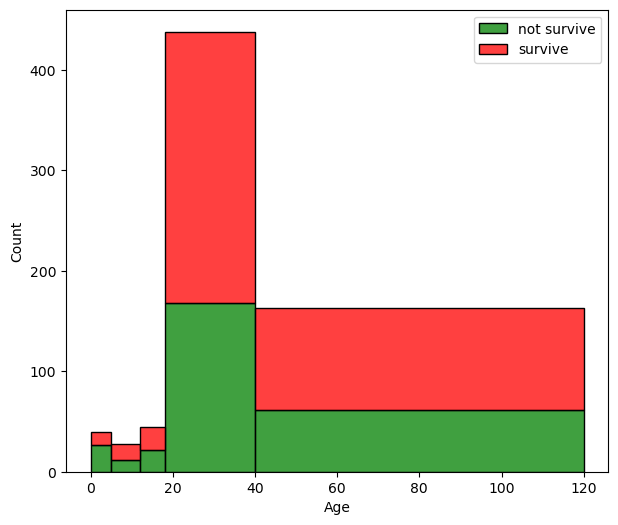

In [3]:
plt.figure(figsize=(7, 6))
# Menggunakan sns.histplot dengan hue untuk memisahkan Survived == 0 dan Survived == 1
sns.histplot(data=df, x="Age", bins=[0, 5, 12, 18, 40, 120], hue="Survived", multiple="stack", palette={0: 'r', 1: 'g'})
plt.legend(['not survive', 'survive'])
plt.show()

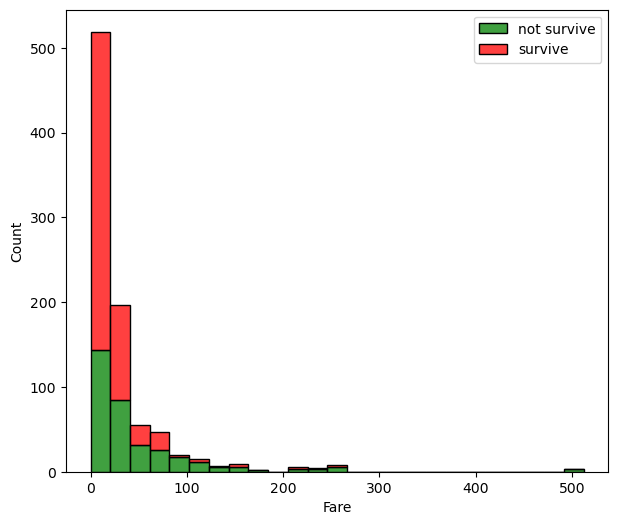

In [4]:
plt.figure(figsize=(7, 6))
# Menggunakan sns.histplot dengan hue untuk memisahkan Survived == 0 dan Survived == 1
sns.histplot(data=df, x="Fare", bins=25, hue="Survived", multiple="stack", palette={0: 'r', 1: 'g'})
plt.legend(['not survive', 'survive'])
plt.show()

## categoric vs target

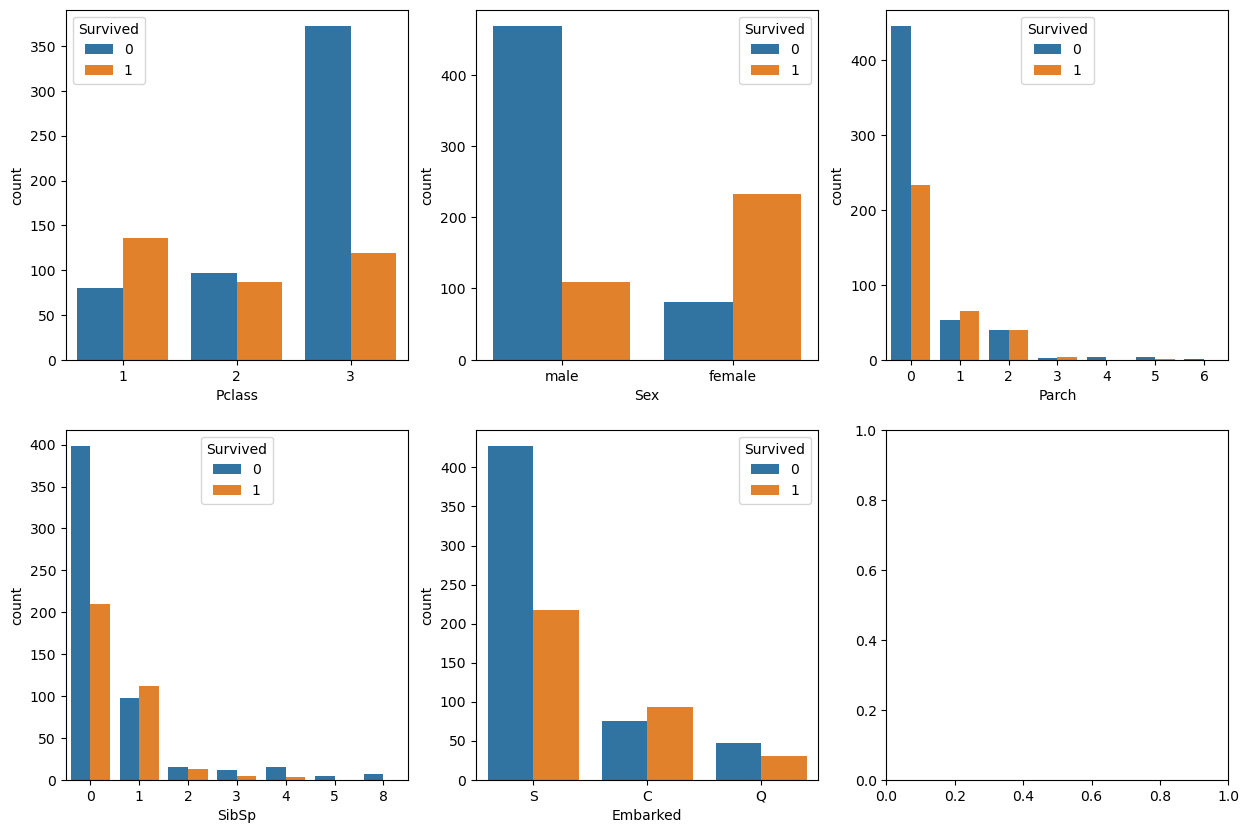

In [5]:
cat_var = ['Pclass', 'Sex', 'Parch', 'SibSp', 'Embarked']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for cat, ax in zip(cat_var, axes.flatten()):
    sns.countplot(x=cat, data=df, hue='Survived', ax=ax)

### pandas crosstab(optional/alternatif)

In [6]:
pd.crosstab(df.Pclass, df.Survived, normalize='index')

Survived,0,1
Pclass,,
1,0.370370,0.629630
2,0.527174,0.472826
3,0.757637,0.242363


# feature engineering (mengolah data)

## adding feature -> isAlone

In [7]:
df['isAlone'] = (df.SibSp == 0) & (df.Parch == 0)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,isAlone
PassengerId,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S,False
2,1,1,female,38.0,1,0,71.2833,C,False
3,1,3,female,26.0,0,0,7.9250,S,True
4,1,1,female,35.0,1,0,53.1000,S,False
5,0,3,male,35.0,0,0,8.0500,S,True


## binning

In [8]:
df.Age = pd.cut(df.Age, [0, 5, 12, 18, 40, 120], labels=['balita', 'anak-anak', 'remaja', 'dewasa', 'lansia'])

In [9]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,isAlone
PassengerId,,,,,,,,,
1,0,3,male,dewasa,1,0,7.2500,S,False
2,1,1,female,dewasa,1,0,71.2833,C,False
3,1,3,female,dewasa,0,0,7.9250,S,True
4,1,1,female,dewasa,1,0,53.1000,S,False
5,0,3,male,dewasa,0,0,8.0500,S,True


In [10]:
# fare
df.Fare = pd.cut(df.Fare, [0, 25, 100, 600], labels=['ekonomi', 'bisnis', 'eksekutif'])

In [11]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,isAlone
PassengerId,,,,,,,,,
1,0,3,male,dewasa,1,0,ekonomi,S,False
2,1,1,female,dewasa,1,0,bisnis,C,False
3,1,3,female,dewasa,0,0,ekonomi,S,True
4,1,1,female,dewasa,1,0,bisnis,S,False
5,0,3,male,dewasa,0,0,ekonomi,S,True


# dataset splitting

In [12]:
# dataset splitting
x = df.drop(columns='Survived')
y = df.Survived

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((712, 8), (179, 8), (712,), (179,))

# preprocessor

In [13]:
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder())
])

preprocessor = ColumnTransformer([
    ('numeric', numerical_pipeline, ['SibSp',  'Parch']),
    ('categoric', categorical_pipeline, ['Pclass', 'Sex', 'Embarked', 'Fare', 'Age', 'isAlone'])
])

# training

In [14]:
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', KNeighborsClassifier())
])

parameter = {
    'algo__n_neighbors': range(1, 29, 2),
    'algo__weights': ['uniform','distance'],
    'algo__p':[1, 2]
}

model = GridSearchCV(pipeline, parameter, cv=3, n_jobs=-1, verbose=1)
model.fit(x_train, y_train)

#evaluation
print(model.best_params_)
print(model.score(x_train, y_train), model.score(x_test, y_test))

Fitting 3 folds for each of 56 candidates, totalling 168 fits
{'algo__n_neighbors': 13, 'algo__p': 1, 'algo__weights': 'uniform'}
0.8328651685393258 0.770949720670391
